In [1]:
base_dir = '/media/ente/M2/2018 - 11 - sorted data'
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax' ]
class_mode = 'categorical'
metrics= ['categorical_accuracy', 'acc' ]
dense_units=2048
batch_size = 20
epochs = 40

#preprocessing
validation_split = 0.2
#color_channels = 3
color_mode='rgb'
#color_mode='grayscale'
target_width = target_height = 299
target_size = (target_height, target_width)

#class dirs
import os
ate_dir = os.path.join(base_dir, class_names[0])
car_dir = os.path.join(base_dir, class_names[1])
con_dir = os.path.join(base_dir, class_names[2])
ede_dir = os.path.join(base_dir, class_names[3])
eff_dir = os.path.join(base_dir, class_names[4])
emp_dir = os.path.join(base_dir, class_names[5])
fib_dir = os.path.join(base_dir, class_names[6])
her_dir = os.path.join(base_dir, class_names[7])
inf_dir = os.path.join(base_dir, class_names[8])
mas_dir = os.path.join(base_dir, class_names[9])
nof_dir = os.path.join(base_dir, class_names[10])
nod_dir = os.path.join(base_dir, class_names[11])
ple_dir = os.path.join(base_dir, class_names[12])
pne_dir = os.path.join(base_dir, class_names[13])
pn2_dir = os.path.join(base_dir, class_names[14])
#filenames
ate_fnames = os.listdir(ate_dir)
car_fnames = os.listdir(car_dir)
con_fnames = os.listdir(con_dir)
ede_fnames = os.listdir(ede_dir)
eff_fnames = os.listdir(eff_dir)
emp_fnames = os.listdir(emp_dir)
fib_fnames = os.listdir(fib_dir)
her_fnames = os.listdir(her_dir)
inf_fnames = os.listdir(inf_dir)
mas_fnames = os.listdir(mas_dir)
nof_fnames = os.listdir(nof_dir)
nod_fnames = os.listdir(nod_dir)
ple_fnames = os.listdir(ple_dir)
pne_fnames = os.listdir(pne_dir)
pn2_fnames = os.listdir(pn2_dir)
#print (train_ate_fnames[:10])
#train_car_fnames.sort()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2
) # set validation split

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size, #default 256x256
    class_mode=class_mode,
    color_mode=color_mode, 
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    base_dir, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode, #Determines the type of label arrays that are returned:"categorical" will be 2D one-hot encoded labels,
    color_mode=color_mode, 
    subset='validation') # set as validation data

print ('total Atelectasis images:       ', len(os.listdir(ate_dir))) 
print ('total Cardiomegaly images:      ', len(os.listdir(car_dir))) 
print ('total Consolidation images:     ', len(os.listdir(con_dir))) 
print ('total Edema images:             ', len(os.listdir(ede_dir))) 
print ('total Effusion images:          ', len(os.listdir(eff_dir))) 
print ('total Emphysema images:         ', len(os.listdir(emp_dir))) 
print ('total Fibrosis images:          ', len(os.listdir(fib_dir))) 
print ('total Hernia images:            ', len(os.listdir(her_dir))) 
print ('total Infiltration images:      ', len(os.listdir(inf_dir))) 
print ('total Mass images:              ', len(os.listdir(mas_dir))) 
print ('total No_Finding images:        ', len(os.listdir(nof_dir))) 
print ('total Nodule images:            ', len(os.listdir(nod_dir))) 
print ('total Pleural_Thickening images:', len(os.listdir(ple_dir))) 
print ('total Pneumonia images:         ', len(os.listdir(pne_dir))) 
print ('total Pneumothorax images:      ', len(os.listdir(pn2_dir))) 

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(dense_units, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(len(class_names), activation = 'softmax') (x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)
model.summary()
# train the model on the new data for a few epochs
history1=model.fit_generator(    
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=metrics)
model.summary()
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2=model.fit_generator(    
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)

Found 34283 images belonging to 15 classes.
Found 8564 images belonging to 15 classes.
total Atelectasis images:        2015
total Cardiomegaly images:       464
total Consolidation images:      633
total Edema images:              310
total Effusion images:           1804
total Emphysema images:          461
total Fibrosis images:           366
total Hernia images:             53
total Infiltration images:       4640
total Mass images:               1043
total No_Finding images:         28000
total Nodule images:             1273
total Pleural_Thickening images: 525
total Pneumonia images:          161
total Pneumothorax images:       1099


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/40
1714/1714 [==============================] - 622s 363ms/step - loss: 5.5865 - categorical_accuracy: 0.6529 - acc: 0.6529 - val_loss: 5.5792 - val_categorical_accuracy: 0.6539 - val_acc: 0.6539
Epoch 2/40
1714/1714 [==============================] - 619s 361ms/step - loss: 5.5859 - categorical_accuracy: 0.6534 - acc: 0.6534 - val_loss: 5.5746 - val_categorical_accuracy: 0.6541 - val_acc: 0.6541
Epoch 3/40
1714/1714 [==============================] - 620s 362ms/step - loss: 5.5829 - categorical_accuracy: 0.6536 - acc: 0.6536 - val_loss: 5.5859 - val_categorical_accuracy: 0.6534 - val_acc: 0.6534
Epoch 4/40
1714/1714 [==============================] - 616s 359ms/step - loss: 5.5871 - categorical_accuracy: 0.6534 - acc: 0.6534 - val_loss: 5.5632 - val_categorical_accuracy: 0.6548 - val_acc: 0.6548
Epoch 5/40
1714/1714 [==============================] - 615s 359ms/step - loss: 5.5887 - categorical_accuracy: 0.6533 - acc: 0.6533 - val_loss: 5.5991 - val_categorical_accuracy: 0.652

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/40
1714/1714 [==============================] - 622s 363ms/step - loss: 5.5923 - categorical_accuracy: 0.6530 - acc: 0.6530 - val_loss: 5.5444 - val_categorical_accuracy: 0.6560 - val_acc: 0.6560
Epoch 2/40
1714/1714 [==============================] - 617s 360ms/step - loss: 5.5860 - categorical_accuracy: 0.6534 - acc: 0.6534 - val_loss: 5.6047 - val_categorical_accuracy: 0.6523 - val_acc: 0.6523
Epoch 3/40
1714/1714 [==============================] - 619s 361ms/step - loss: 5.5873 - categorical_accuracy: 0.6534 - acc: 0.6534 - val_loss: 5.5632 - val_categorical_accuracy: 0.6548 - val_acc: 0.6548
Epoch 4/40
1714/1714 [==============================] - 618s 360ms/step - loss: 5.5769 - categorical_accuracy: 0.6540 - acc: 0.6540 - val_loss: 5.6481 - val_categorical_accuracy: 0.6496 - val_acc: 0.6496
Epoch 5/40
1714/1714 [==============================] - 615s 359ms/step - loss: 5.5891 - categorical_accuracy: 0.6532 - acc: 0.6532 - val_loss: 5.5632 - val_categorical_accuracy: 0.654

KeyboardInterrupt: 

Text(0.5,1,'Training and validation loss')

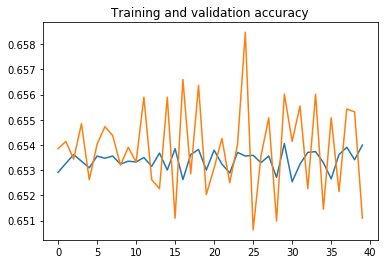

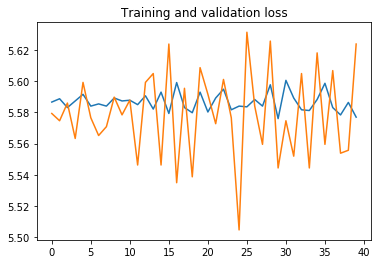

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history1.history['acc']
val_acc = history1.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [3]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history2.history['acc']
val_acc = history2.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

NameError: name 'history2' is not defined